* ### Goal: Solving specific captcha style provided with highest accuracy possible
* ### Dataset: 1070 captcha images with labels

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential

In [3]:
#Basic settings 
dataset_path = "../input/captcha-version-2-images/samples/samples"
seed = 2021
epochs = 100
width = 200
height = 50
learning_rate = 0.001
batch_num = 16

In [4]:
#Load images with labels
images_data = []
labels_data = []
for image_name in os.listdir(dataset_path):
    labels_data.append(str(image_name.split(".")[0])) #Delete .png extenstion and add label to array
    actual_image = cv2.imread(os.path.join(dataset_path, image_name), cv2.IMREAD_GRAYSCALE)
    images_data.append(actual_image)

In [53]:
len(images_data)

1070

37d52


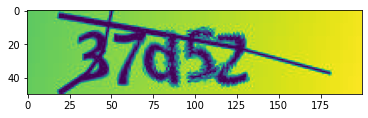

In [5]:
#Show last image and print its label
plt.imshow(images_data[-1])
print(labels_data[-1])

In [6]:
#Check which characters appear in captcha
possible_characters = set("".join(labels_data))
print(possible_characters)

{'8', 'p', 'e', 'y', 'd', '4', 'b', 'f', '2', '5', 'g', '3', 'x', 'c', 'n', 'w', '6', '7', 'm'}


In [7]:
#Create dict which assign one number for each character and vice versa
char2num = {}
num2char = {}
for i, char in enumerate(possible_characters):
    char2num[char] = i
    num2char[i] = char
char_count = len(possible_characters)

In [8]:
char2num

{'8': 0,
 'p': 1,
 'e': 2,
 'y': 3,
 'd': 4,
 '4': 5,
 'b': 6,
 'f': 7,
 '2': 8,
 '5': 9,
 'g': 10,
 '3': 11,
 'x': 12,
 'c': 13,
 'n': 14,
 'w': 15,
 '6': 16,
 '7': 17,
 'm': 18}

In [9]:
#Function which takes string label and transform it into neural net readable raw data
def label_to_raw(label):
    raw = np.zeros(char_count * 5)
    for i, char in enumerate(label):
        raw[(i * char_count) + char2num[char]] = 1
    return raw

#Vice versa
def raw_to_label(raw):
    label = ""
    for i, val in enumerate(raw):
        if val == 1:
            label += num2char[i % char_count]
    return label

In [10]:
#Test function
print(labels_data[-1])
raw_test = label_to_raw(labels_data[-1])
print(raw_test)
print(raw_to_label(raw_test))

37d52
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
37d52


In [11]:
#We can now preprocess all labels to raw data
raw_labels = np.array([label_to_raw(label) for label in labels_data])

#And change images into numpy array
raw_images = np.array(images_data).reshape(-1, height, width, 1)

#At the and check if shapes are correct 
print(raw_labels.shape) #For labels (num_of_examples, num_of_chars * 5)
print(raw_images.shape) #For images (num_of_examples, height, width, 1)

(1070, 95)
(1070, 50, 200, 1)


In [23]:
#Lets create simple CNN model
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, activation="relu", padding="same", input_shape=[200, 50, 1]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128,activation="relu"),
    keras.layers.Dense(64,activation="relu"),
    keras.layers.Dense(char_count * 5, activation="sigmoid")
])

In [24]:
#Compile model
optimizer = keras.optimizers.Adam()
loss = keras.losses.BinaryCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics=["binary_accuracy", "Recall", "Precision"])

In [22]:
#Create callbacks
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=learning_rate)
checkpoints = keras.callbacks.ModelCheckpoint("mode.h5", monitor='binary_accuracy', mode="max")
earlystop = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', mode="max", patience=7)

In [25]:
#Model training
history = model.fit(x=raw_images, y=raw_labels, batch_size=batch_num, validation_split=0.2, epochs=epochs, callbacks=[checkpoints, earlystop, reduce_lr])

Epoch 1/100
54/54 [==============================] - 3s 27ms/step - loss: 5.6189 - binary_accuracy: 0.6795 - recall: 0.3067 - precision: 0.0539 - val_loss: 0.2735 - val_binary_accuracy: 0.9227 - val_recall: 0.0243 - val_precision: 0.0469
Epoch 2/100
54/54 [==============================] - 1s 16ms/step - loss: 0.2386 - binary_accuracy: 0.9413 - recall: 0.0106 - precision: 0.0824 - val_loss: 0.1979 - val_binary_accuracy: 0.9474 - val_recall: 0.0028 - val_precision: 0.6000
Epoch 3/100
54/54 [==============================] - 1s 15ms/step - loss: 0.1869 - binary_accuracy: 0.9478 - recall: 0.0132 - precision: 0.7061 - val_loss: 0.1867 - val_binary_accuracy: 0.9474 - val_recall: 0.0121 - val_precision: 0.5200
Epoch 4/100
54/54 [==============================] - 1s 16ms/step - loss: 0.1718 - binary_accuracy: 0.9485 - recall: 0.0364 - precision: 0.7133 - val_loss: 0.1877 - val_binary_accuracy: 0.9475 - val_recall: 0.0467 - val_precision: 0.5155
Epoch 5/100
54/54 [=============================

In [26]:
model.predict(raw_images)[1]

array([1.20153695e-01, 4.13532580e-05, 6.11509604e-04, 5.14891837e-03,
       3.22162727e-04, 2.22974792e-04, 4.30568209e-04, 9.77004468e-01,
       2.09163176e-03, 1.01649754e-01, 3.33847431e-03, 7.73318519e-04,
       1.71043053e-02, 6.02521468e-04, 9.69870656e-04, 2.88694806e-04,
       1.44874124e-04, 2.89383880e-03, 1.16244246e-05, 1.82191376e-02,
       1.28906742e-01, 5.85486647e-04, 8.86135895e-05, 1.24945231e-02,
       2.31157060e-06, 9.74620506e-02, 4.90912888e-03, 8.22715356e-06,
       1.22292385e-01, 1.40642794e-03, 4.42671211e-04, 3.38197628e-04,
       2.93090216e-05, 6.65396154e-01, 1.43663108e-03, 4.98078093e-02,
       1.38261151e-02, 6.69806125e-03, 5.93774132e-07, 7.16376962e-06,
       1.28858126e-04, 5.82218272e-05, 3.16451653e-03, 3.73182558e-02,
       1.03948731e-03, 3.21603031e-03, 9.90351960e-02, 6.87881093e-03,
       4.44660969e-02, 3.23916931e-04, 8.97923578e-03, 1.86639000e-02,
       2.91009923e-03, 3.03015066e-03, 5.79317624e-04, 4.62825038e-03,
      

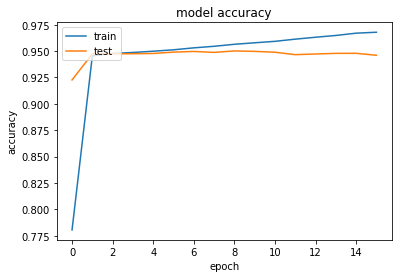

In [27]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

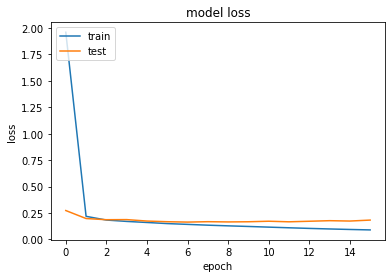

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
#Lets create own function for predicting so its most accurate as possible
def solve_captchas(images):
    outputs = []
    probs = model.predict(images)
    for prob in probs:
        output = ""
        for i in range(5):
            argmax_id = np.argmax(prob[i*char_count:(i+1)*char_count])
            output += str(num2char[argmax_id])
        outputs.append(output)
    return outputs

In [43]:
solve_captchas(raw_images)[0:5]

['6n6np', 'fn2nf', 'nxf2c', 'nbwnn', 'ebcx7']

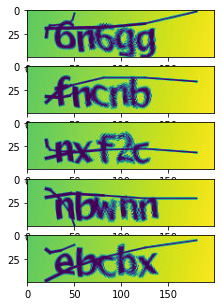

In [52]:
fig = plt.figure(figsize=(10, 5))
for i in range(5):
    fig.add_subplot(5, 1, i+1)
    plt.imshow(images_data[i])